In [1]:
import pandas as pd
import sys
sys.path.append('../utils')
import visualization as visualization
import generic as generic
import project_utils as project_utils
import numpy as np
import matplotlib.pyplot as plt
import importlib



pygame 2.6.1 (SDL 2.28.4, Python 3.11.10)
Hello from the pygame community. https://www.pygame.org/contribute.html


### Load Data

In [2]:
dengue_data = pd.read_csv('../data/processed/dengue_data_with_coordinates.csv')
daily_ovitraps = pd.read_csv('../data/processed/daily_ovitraps.csv',index_col=0, parse_dates=True)
ovitraps_data = pd.read_csv('../data/processed/ovitraps_data_with_coordinates.csv')


### Constants

In [3]:
epidemic_years = ['2012_13', '2015_16', '2018_19', '2023_24']

epidemic_date_range = {}
for year in epidemic_years:
    epidemic_year_df = ovitraps_data[ovitraps_data['anoepid'] == year].copy()
    epidemic_date_range[year] = (epidemic_year_df['dtcol'].min(), epidemic_year_df['dtcol'].max())



In [4]:
epidemic_days = [pd.date_range(start=epidemic_date_range[year][0], end=epidemic_date_range[year][1]) for year in epidemic_years]
epidemic_days_flat = [day.strftime('%Y-%m-%d') for period in epidemic_days for day in period]


### Process Data

In [5]:
# Dengue data
daily_dengue_data = project_utils.get_daily_dengue(dengue_data)

# ovitraps data
daily_ovitraps_sum = daily_ovitraps.sum(axis=1)
daily_ovitraps_mean = daily_ovitraps.mean(axis=1)

### Plot data

#### Dengue

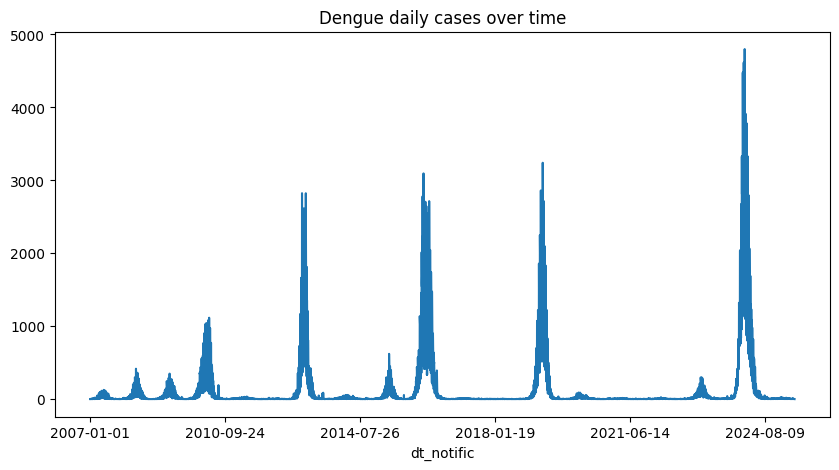

In [6]:
daily_dengue_data.plot(kind='line', figsize=(10, 5), title='Dengue daily cases over time')
plt.show()


#### Ovitraps

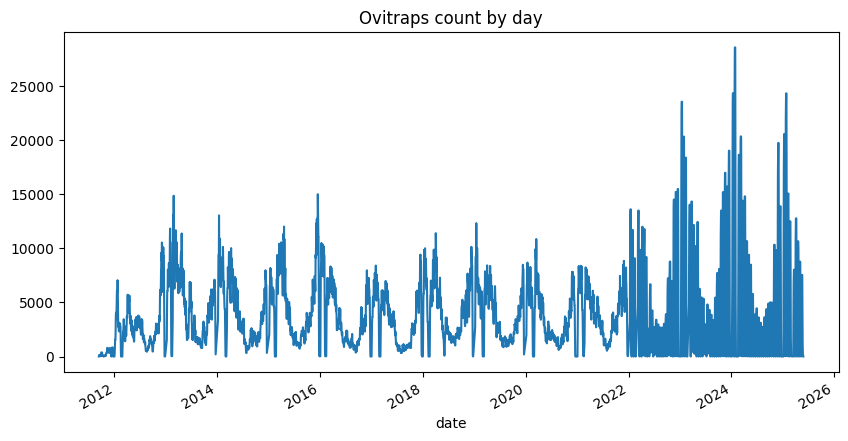

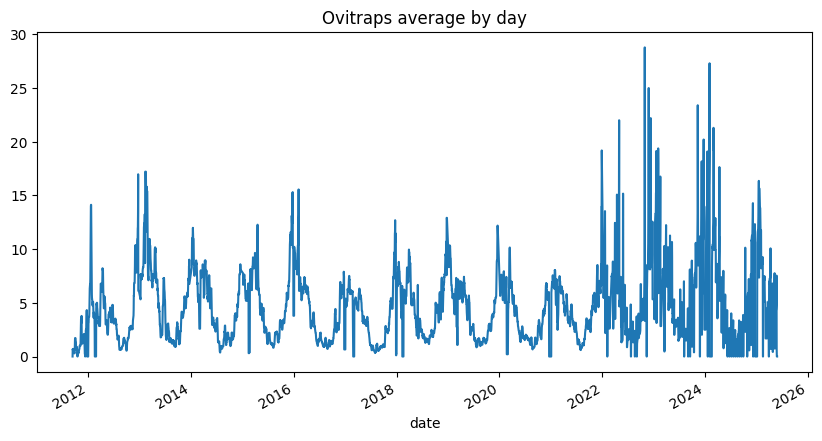

In [7]:
daily_ovitraps_sum.plot(kind='line', figsize=(10, 5), title='Ovitraps count by day')
plt.show()
daily_ovitraps_mean.dropna().plot(kind='line', figsize=(10, 5), title='Ovitraps average by day')
plt.show()

# Correlation Analysis

### All years

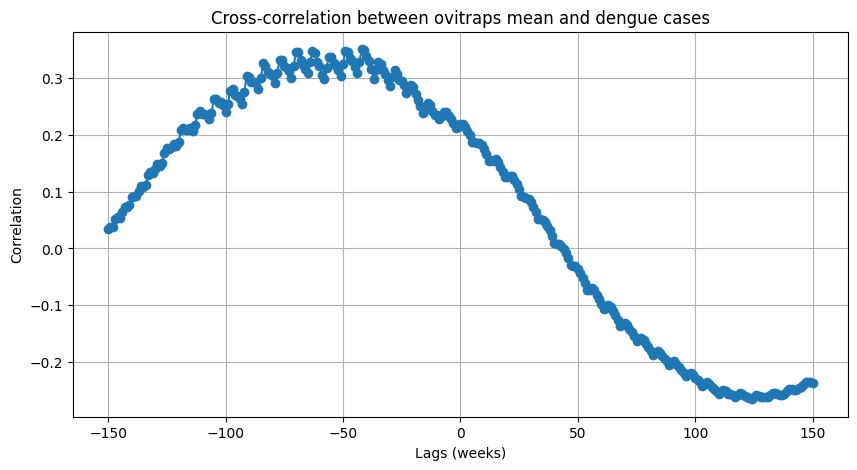

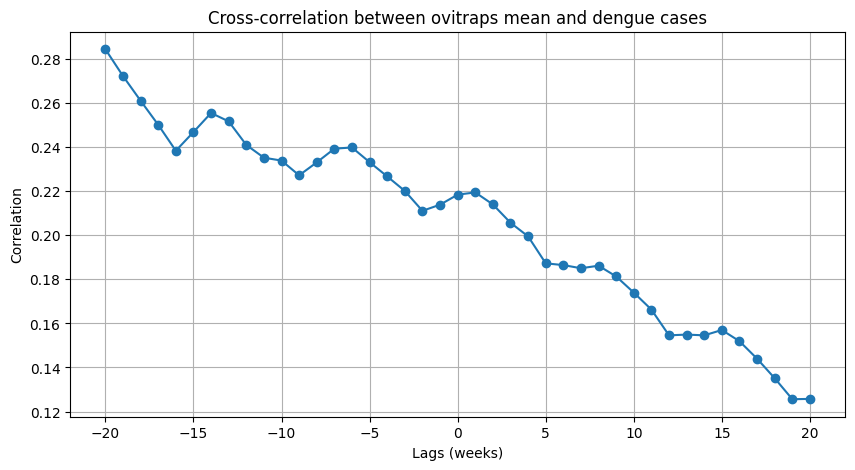

In [8]:
generic.plot_cross_correlation(
    series_1 = daily_ovitraps_mean,
    series_2 = daily_dengue_data,
    max_lag =  150,
    title = 'Cross-correlation between ovitraps mean and dengue cases',
    x_label = 'Lags (weeks)',
    )

generic.plot_cross_correlation(
    series_1 = daily_ovitraps_mean,
    series_2 = daily_dengue_data,
    max_lag =  20,
    title = 'Cross-correlation between ovitraps mean and dengue cases',
    x_label = 'Lags (weeks)',

    )

### Epidemic years


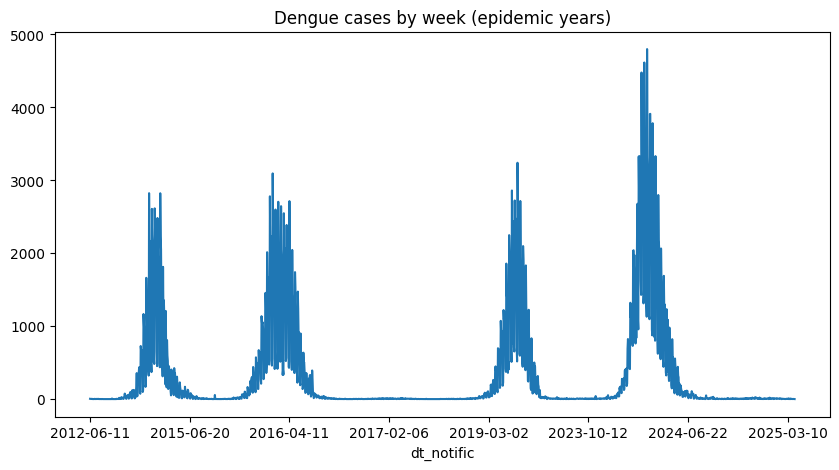

In [9]:
epidemic_mask = daily_dengue_data.index.map(lambda x: x in epidemic_days_flat)
daily_dengue_data_epidemic = daily_dengue_data[epidemic_mask]
daily_dengue_data_epidemic.plot(kind='line', figsize=(10, 5), title='Dengue cases by week (epidemic years)')
daily_dengue_data_epidemic.index = daily_dengue_data_epidemic.index.map(lambda x: pd.to_datetime(x, format='%Y-%m-%d'))


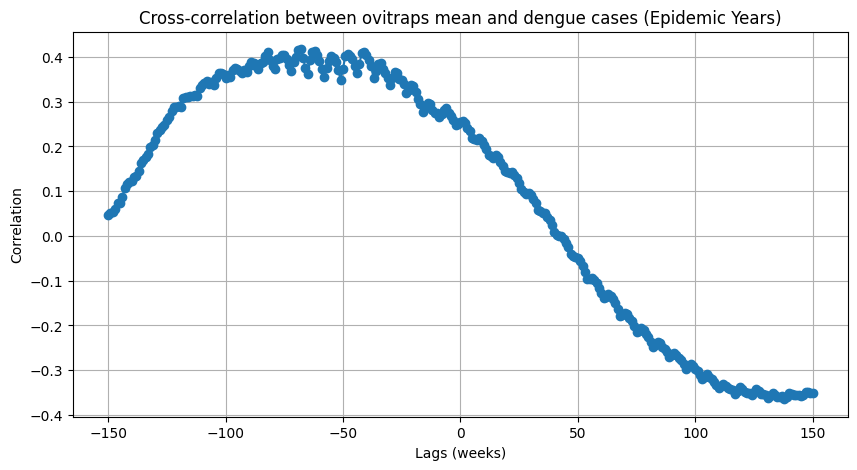

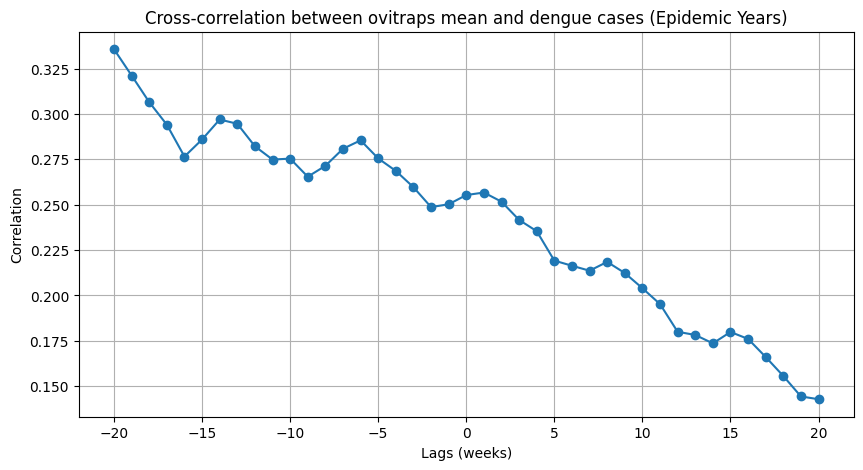

In [10]:
generic.plot_cross_correlation(
    series_1 = daily_ovitraps_mean,
    series_2 = daily_dengue_data_epidemic,
    max_lag =  150,
    title = 'Cross-correlation between ovitraps mean and dengue cases (Epidemic Years)',
    x_label = 'Lags (weeks)',
    )

generic.plot_cross_correlation(
    series_1 = daily_ovitraps_mean,
    series_2 = daily_dengue_data_epidemic,
    max_lag =  20,
    title = 'Cross-correlation between ovitraps mean and dengue cases (Epidemic Years)',
    x_label = 'Lags (weeks)',
    )

### Non epidemic years

<Axes: title={'center': 'Dengue cases by week (epidemic years)'}, xlabel='dt_notific'>

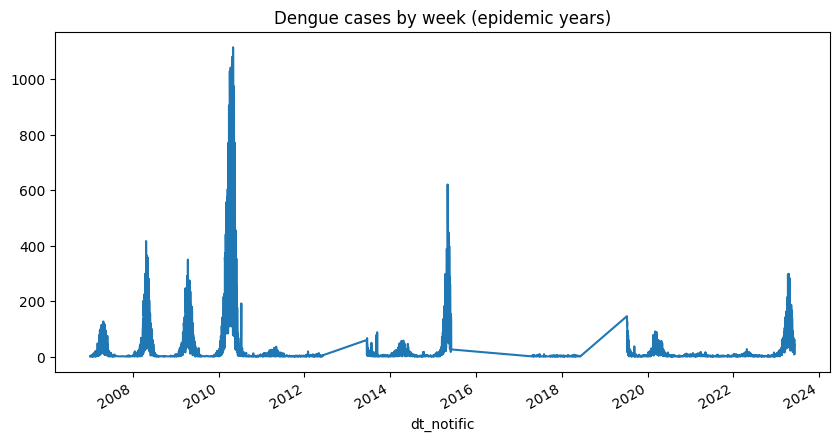

In [11]:
daily_dengue_data_non_epidemic = daily_dengue_data[~epidemic_mask]
daily_dengue_data_non_epidemic.index = daily_dengue_data_non_epidemic.index.map(lambda x: pd.to_datetime(x, format='%Y-%m-%d'))
daily_dengue_data_non_epidemic.plot(kind='line', figsize=(10, 5), title='Dengue cases by week (epidemic years)')


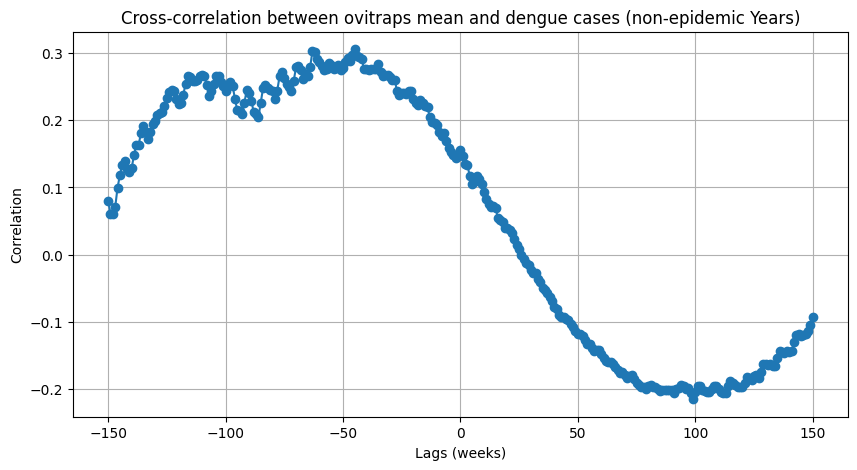

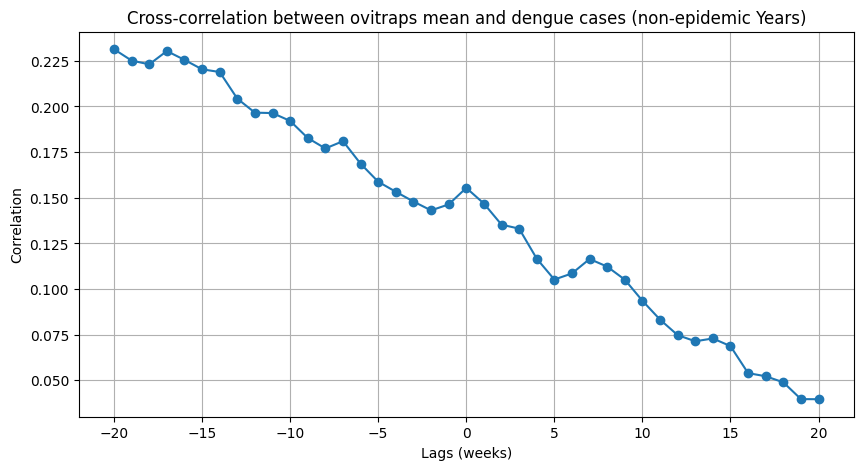

In [12]:
# Filter non epidemic years
generic.plot_cross_correlation(
    series_1 = daily_ovitraps_mean,
    series_2 = daily_dengue_data_non_epidemic,
    max_lag =  150,
    title = 'Cross-correlation between ovitraps mean and dengue cases (non-epidemic Years)',
    x_label = 'Lags (weeks)',
    )

generic.plot_cross_correlation(
    series_1 = daily_ovitraps_mean,
    series_2 = daily_dengue_data_non_epidemic,
    max_lag =  20,
    title = 'Cross-correlation between ovitraps mean and dengue cases (non-epidemic Years)',
    x_label = 'Lags (weeks)',
    )

### Correlation by year

In [13]:
dengue_data.columns

Index(['dt_notific', 'CodMun', 'semepid', 'dt_nasc', 'nu_idade_n', 'Sexo',
       'id_bairro', 'nm_bairro', 'classi_fin', 'dt_obito', 'coordx', 'coordy',
       'diagnostic', 'abrange', 'cdabrange', 'ano', 'Mes_Caso', 'Dia_Caso',
       'DiaC', 'MesC', 'AnoC', 'Dengue', 'Idade', 'anoepid', 'nanoCepid',
       'Mes_Epid', 'Cseason', 'Clustro', 'Cquinzena', 'Cquinzepid',
       'CaClustro', 'cddist', 'distrito', 'qdnte', 'longitude', 'latitude'],
      dtype='object')

In [14]:
all_years = dengue_data.anoepid.unique()
all_years.sort()
max_correlation_dict = {}
for year in all_years:
    year_mask = daily_dengue_data.index.map(lambda x: x[:7] == year)
    year_data = daily_dengue_data[year_mask]
    try:
        if year in epidemic_years:
            marker = '*'
        else:
            marker = ''    
        # Plot cross-correlation for each year
        generic.plot_cross_correlation(
            series_1 = daily_ovitraps_mean,
            series_2 = year_data,
            max_lag =  20,
            title = f'Cross-correlation between ovitraps mean and dengue cases in {year}{marker}',
            x_label = 'Lags (weeks)',
            )
        plt.show()
        
        # Get the maximum correlation for each year
        max_correlation_dict[year] = generic.max_correlation(
                                    series_1 = daily_ovitraps_mean,
                                    series_2 = year_data,
                                    max_lag =  50,
                                            )
    except ValueError as e:
        print(f"Skipping year {year} due to error: {e}")
        continue

Skipping year 2006_07 due to error: Both series must have at least one valid value to calculate correlation.
Skipping year 2007_08 due to error: Both series must have at least one valid value to calculate correlation.
Skipping year 2008_09 due to error: Both series must have at least one valid value to calculate correlation.
Skipping year 2009_10 due to error: Both series must have at least one valid value to calculate correlation.
Skipping year 2010_11 due to error: Both series must have at least one valid value to calculate correlation.
Skipping year 2011_12 due to error: Both series must have at least one valid value to calculate correlation.
Skipping year 2012_13 due to error: Both series must have at least one valid value to calculate correlation.
Skipping year 2013_14 due to error: Both series must have at least one valid value to calculate correlation.
Skipping year 2014_15 due to error: Both series must have at least one valid value to calculate correlation.
Skipping year 2015_

## Maximum correlation

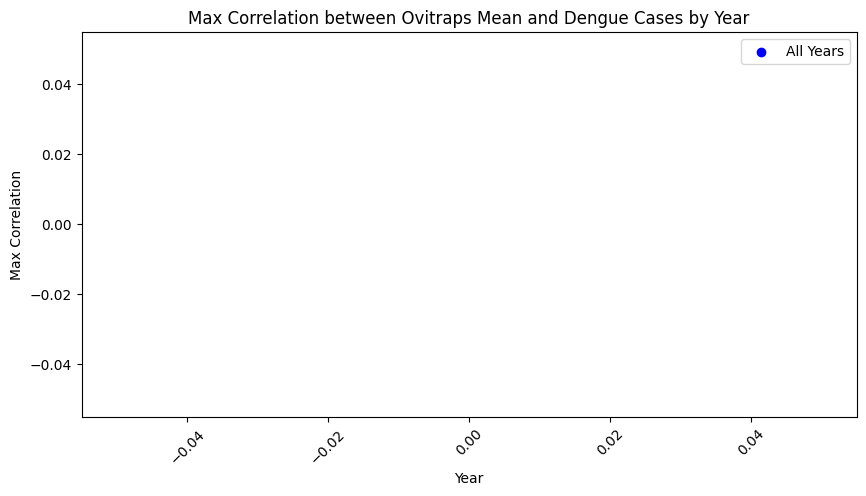

In [15]:
# Plot max correlations for all years
plt.figure(figsize=(10, 5))
plt.scatter(max_correlation_dict.keys(), [v[1] for v in max_correlation_dict.values()], color='blue', label='All Years')
plt.ylabel('Max Correlation')
plt.xlabel('Year')
plt.xticks(rotation=45)
plt.legend()
plt.title('Max Correlation between Ovitraps Mean and Dengue Cases by Year')
plt.show()


# Scatter Plots

### All years

In [16]:
shift = -7

generic.two_series_scatter_plot(daily_ovitraps_mean,
                                daily_dengue_data,
                                series_2_shift = shift,
                                title = 'All Years Scatter Plot - no truncation',
                                xlabel='Ovitraps Mean',
                                ylabel=f'Dengue Cases (Shifted by {shift} days)',
                                )   

generic.two_series_scatter_plot(daily_ovitraps_mean,
                                daily_dengue_data,
                                series_2_shift = shift,
                                title = 'All Years Scatter Plot - truncated in 1000',
                                xlabel='Ovitraps Mean',
                                ylabel=f'Dengue Cases (Shifted by {shift} days)',
                                ylim=(0, 1000),
                                )   


ValueError: Both series must have at least one valid value to plot.

### Epidemic years

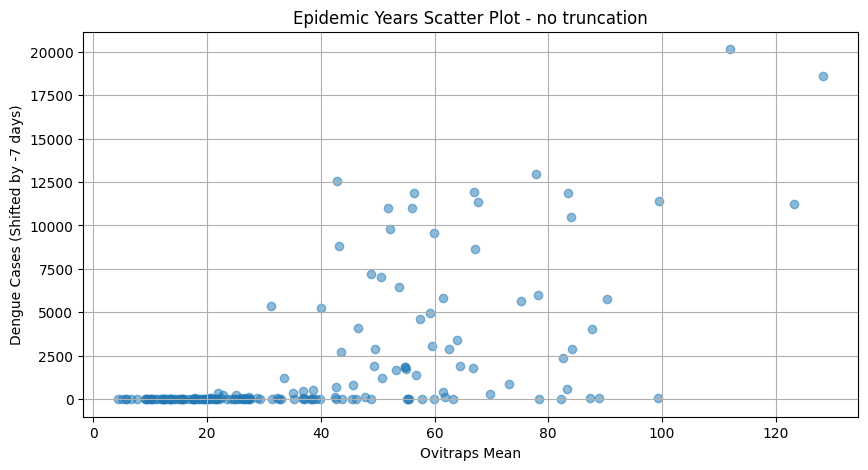

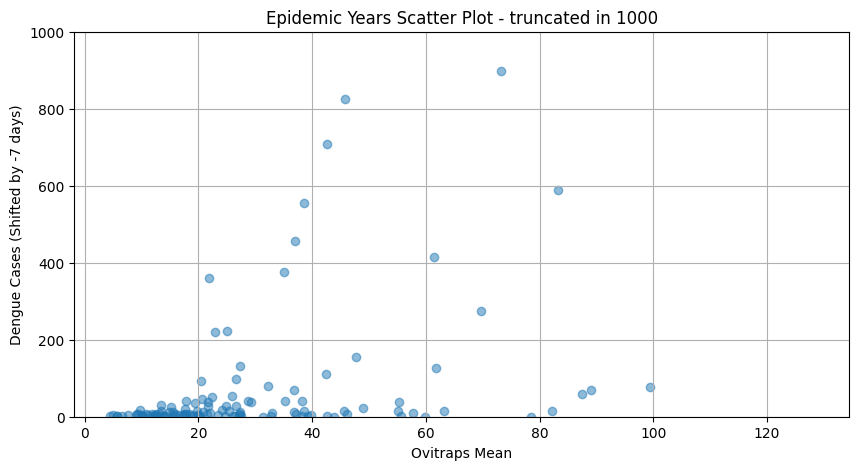

In [ ]:
shift = -7

generic.two_series_scatter_plot(daily_ovitraps_mean,
                                daily_dengue_data_epidemic,
                                series_2_shift = shift,
                                title = 'Epidemic Years Scatter Plot - no truncation',
                                xlabel='Ovitraps Mean',
                                ylabel=f'Dengue Cases (Shifted by {shift} days)',
                                )   

generic.two_series_scatter_plot(daily_ovitraps_mean,
                                daily_dengue_data_epidemic,
                                series_2_shift = shift,
                                title = 'Epidemic Years Scatter Plot - truncated in 1000',
                                xlabel='Ovitraps Mean',
                                ylabel=f'Dengue Cases (Shifted by {shift} days)',
                                ylim=(0, 1000),
                                )   


### Non epidemic years

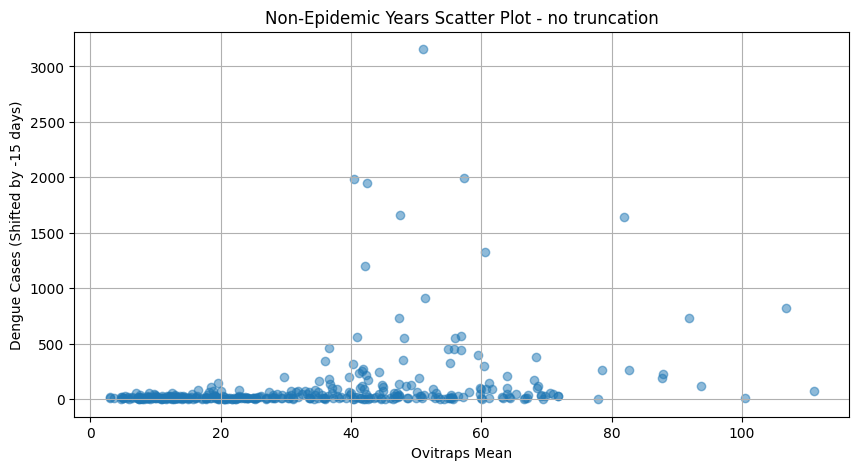

In [ ]:
shift = -15

generic.two_series_scatter_plot(daily_ovitraps_mean,
                                daily_dengue_data_non_epidemic,
                                series_2_shift = shift,
                                title = 'Non-Epidemic Years Scatter Plot - no truncation',
                                xlabel='Ovitraps Mean',
                                ylabel=f'Dengue Cases (Shifted by {shift} days)',
                                )   


### Year by year

Skipping year 2006_07 due to error: Both series must have at least one valid value to plot.
Skipping year 2007_08 due to error: Both series must have at least one valid value to plot.
Skipping year 2008_09 due to error: Both series must have at least one valid value to plot.
Skipping year 2009_10 due to error: Both series must have at least one valid value to plot.
Skipping year 2010_11 due to error: Both series must have at least one valid value to plot.
Skipping year 2011_12 due to error: Both series must have at least one valid value to plot.


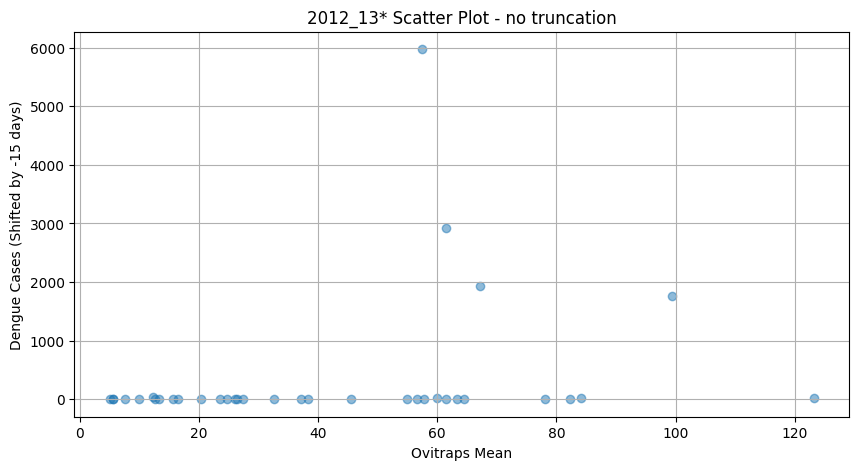

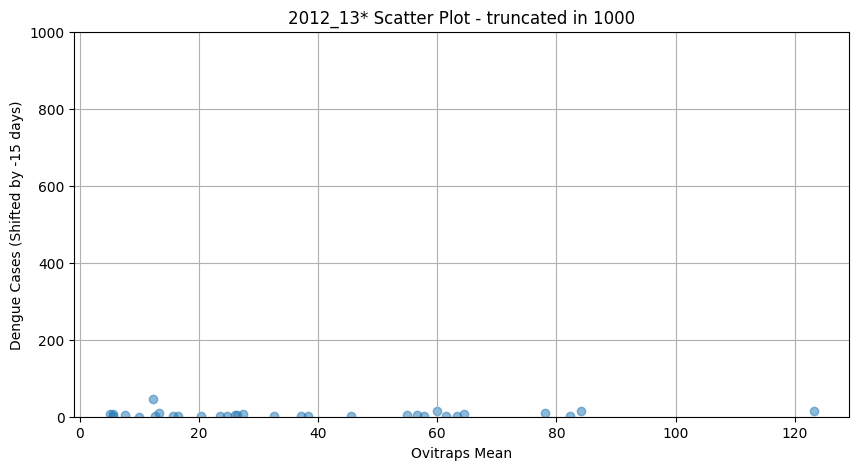

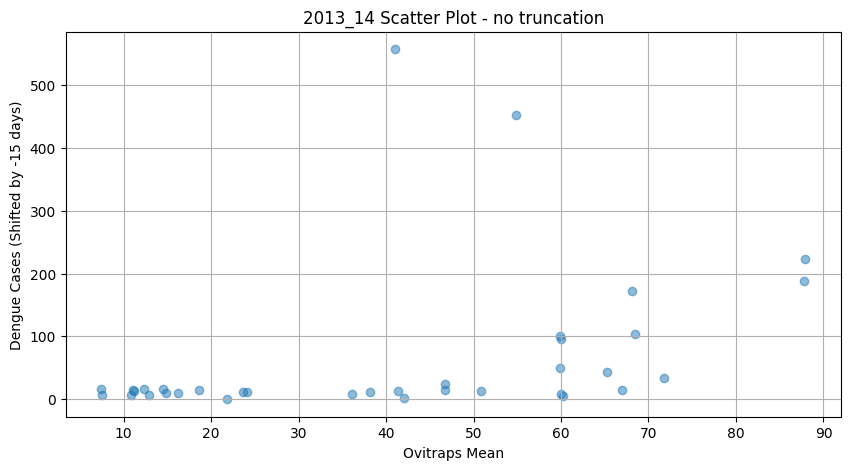

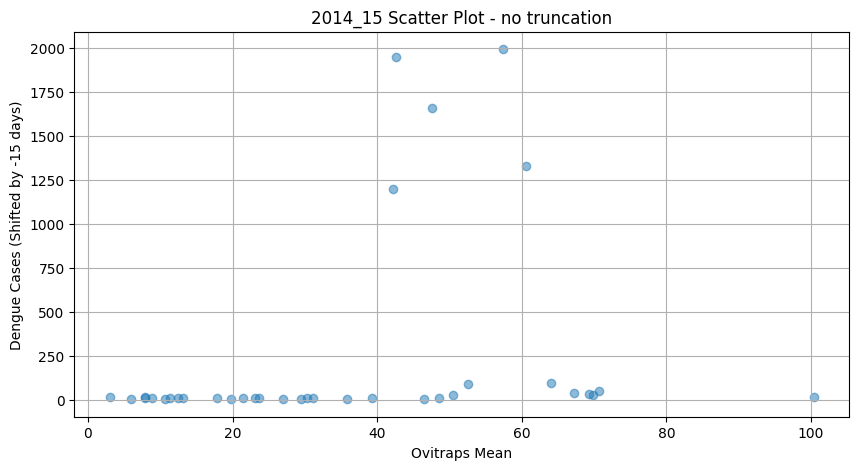

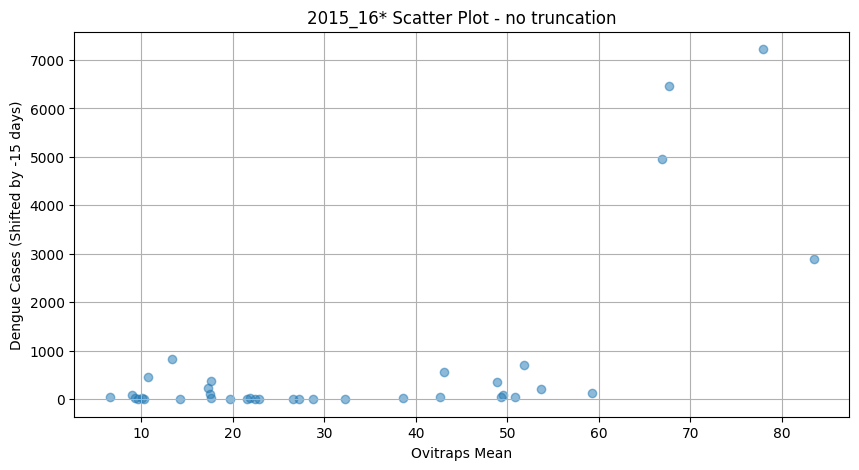

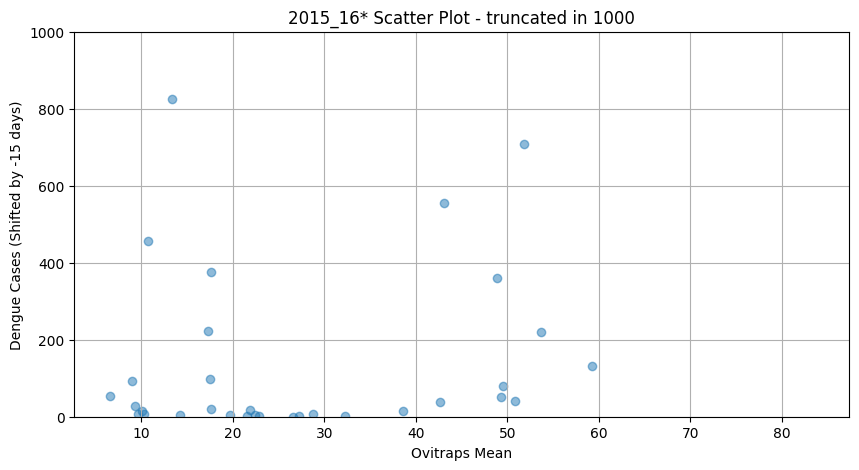

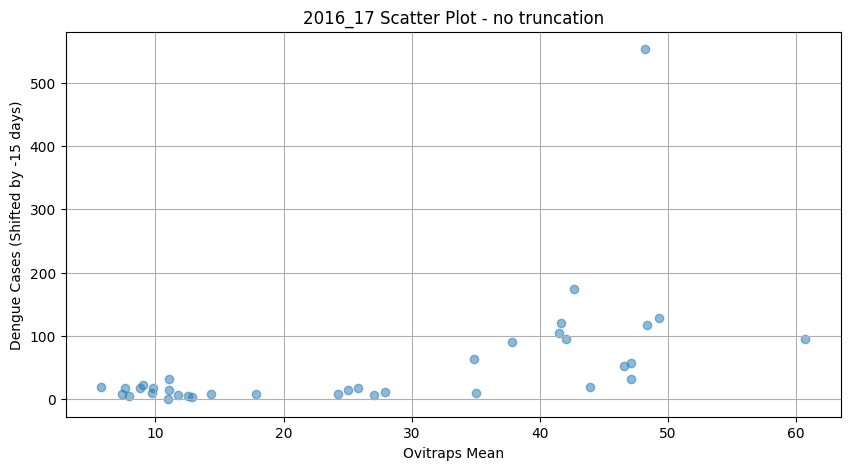

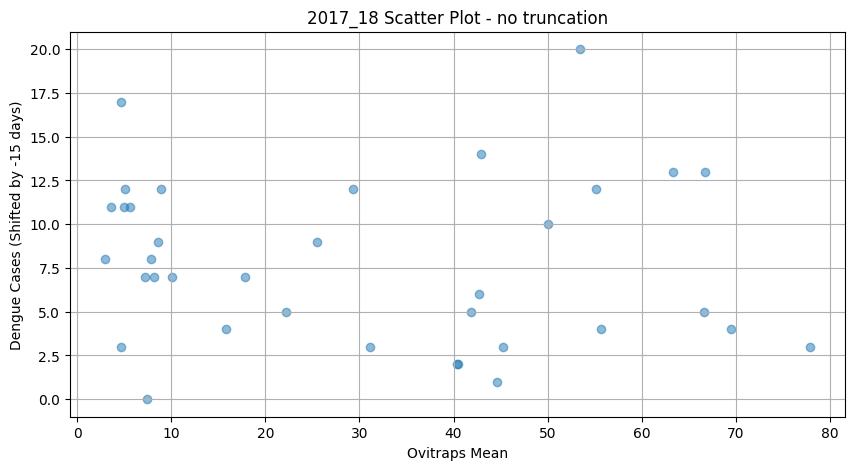

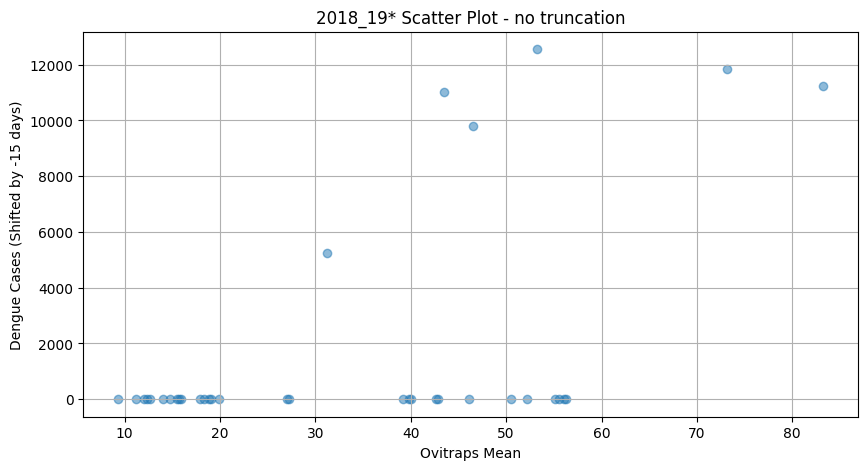

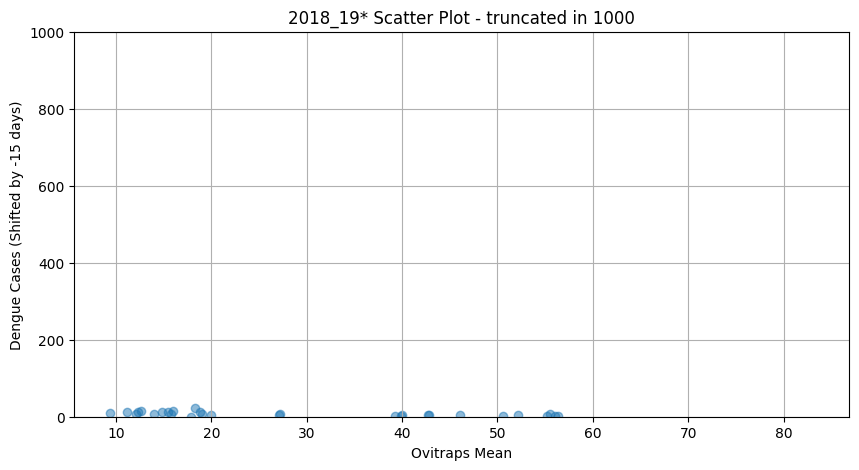

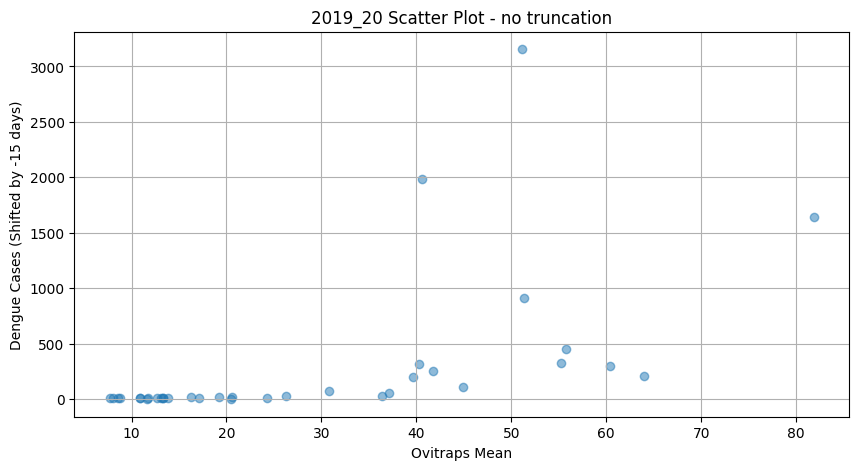

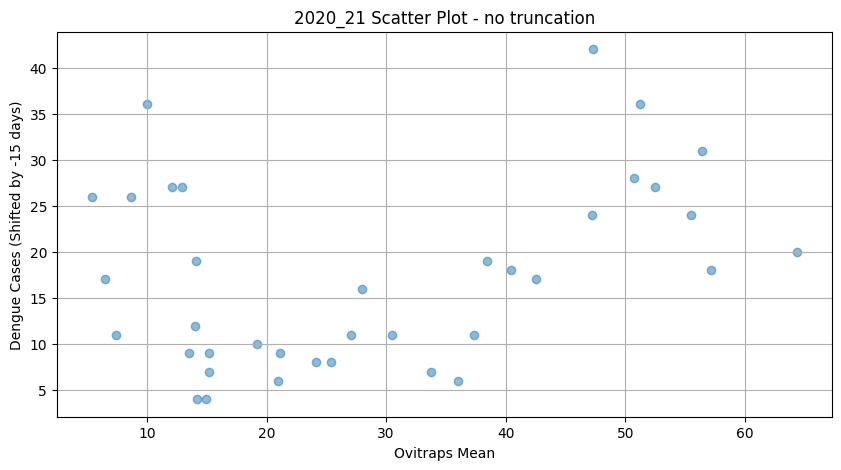

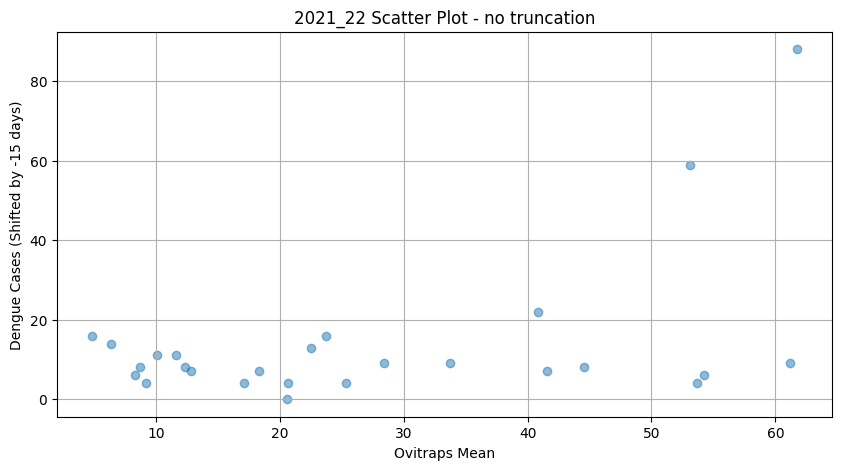

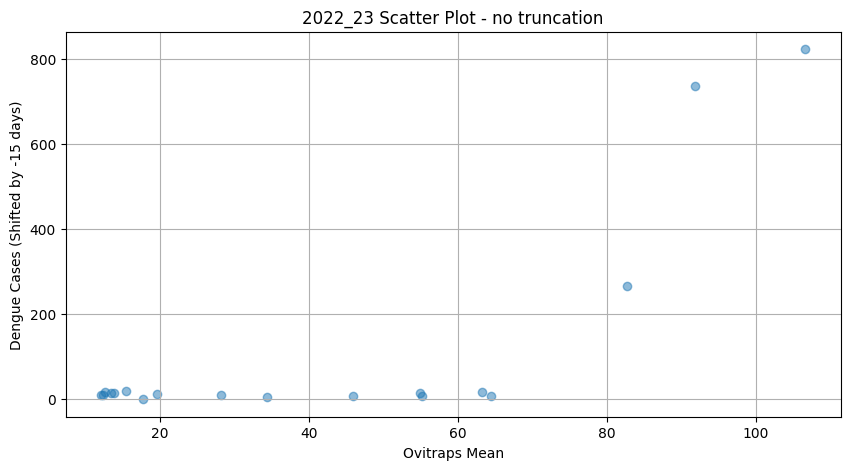

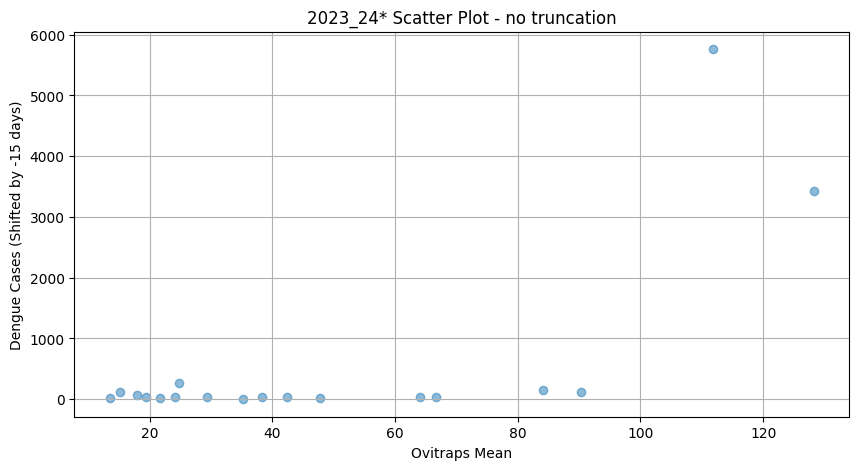

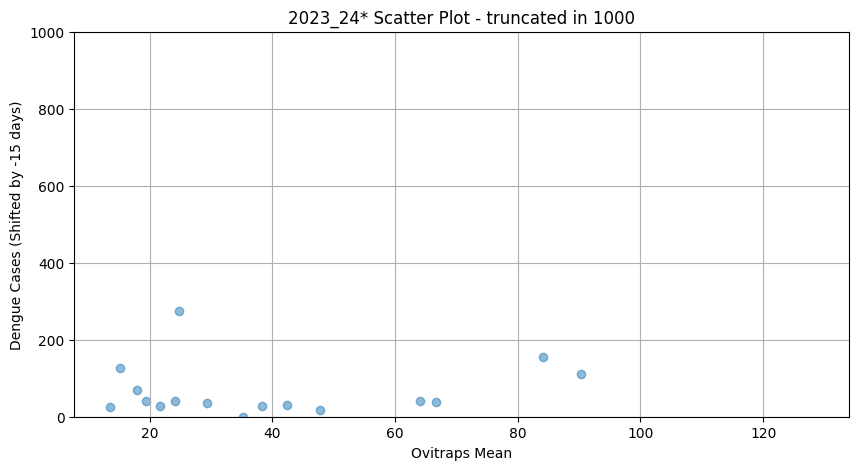

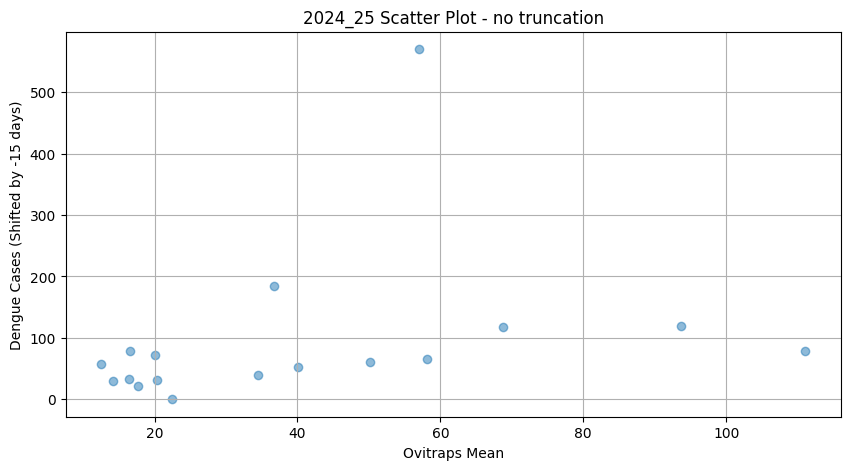

In [ ]:
all_years = dengue_data.anoepid.unique()
all_years.sort()
max_correlation_dict = {}
for year in all_years:
    year_mask = daily_dengue_data.index.map(lambda x: x[:7] == year)
    year_data = daily_dengue_data[year_mask]
    try:
        if year in epidemic_years:

            marker = '*'
        else:
            marker = ''    
        # Plot cross-correlation for each year
        generic.two_series_scatter_plot(daily_ovitraps_mean,
                                year_data,
                                series_2_shift = shift,
                                title = f'{year}{marker} Scatter Plot - no truncation',
                                xlabel='Ovitraps Mean',
                                ylabel=f'Dengue Cases (Shifted by {shift} days)',
                                )  
        if year in epidemic_years:
            generic.two_series_scatter_plot(daily_ovitraps_mean,
                                    year_data,
                                    series_2_shift = shift,
                                    title = f'{year}{marker} Scatter Plot - truncated in 1000',
                                    xlabel='Ovitraps Mean',
                                    ylabel=f'Dengue Cases (Shifted by {shift} days)',
                                    ylim=(0, 1000),
                                    )   
    except ValueError as e:
        print(f"Skipping year {year} due to error: {e}")
        continue